## Fine-tuning tutorial for Evo2: Adapt the 1b evo2 checkpoint for your hardware
Deploy tutorial on brev.dev:  [![ Click here to deploy.](https://brev-assets.s3.us-west-1.amazonaws.com/nv-lb-dark.svg)](https://console.brev.dev/launchable/deploy?launchableID=env-2txhnc7Mzv16BXgal7WAJGnMKUB) 

This is a tutorial demonstrating how you can fine-tune Evo2 on new data and/or hardware. The tutorial should take 
slightly under 1 hour to run on an RTX A6000 in bf16 precision.

To motivate this tutorial, we have noticed that the public
evo2 checkpoint in hugging face for the 1b model is sensitive to `--fp8` status in training. If you want to infer or score new
data, you need FP8 enabled since it was trained that way. Interestingly the `7b` checkpoint does not suffer from this
limitation and seems robust to FP8 being activated or not. The consequence of this is that if you have older GPUs with
a compute capability less than 8.9, which do not support FP8, then the output that you get from scoring sequences with
sensitive checkpoints may not be biologically meaningful. We have observed 0.5 AUCs in these situations. We plan on making
a `1b` parameter evo2 checkpoint available soon that has been fine-tuned to be robust to FP8 or BF16 inference in bionemo
on NGC, but in the meantime this notebook tutorial outlines the steps for fine-tuning. The only difference between this
notebook and what we did in production was to run these steps on more data on a slurm cluster to increase the global
batch size. That said, if you run this for enough steps to get loss on the 1b checkpoint to the 1.08 range, you should 
have good luck with downstream sequence scoring tasks. 

To test this, please supply the path to the saved checkpoint produced by this notebook as the `--ckpt-dir {checkpoint_path}`
argument to the `predict_evo2` command in the zero shot BRCA tutorial. For the 1b checkpoint you should see AUC above
0.73 if you successfully fine-tuned the checkpoint for your hardware, or to check that your hardware works with the 
converted checkpoint from hugging face as is.

As configured, this tutorial requires an NVIDIA GPU with approximately 45GB of ram. If you have multiple GPUs with less
memory, or you are having trouble with CUDA OOM at the training step below, try reducing the `--micro-batch-size` and/or
increasing the number of `--devices [int]` to match your setup and also setting `--tensor-parallel-size [int]` to
the number of devices. This should split up most of the model evenly between your devices, which will require much less
memory. When we train the 1b model in practice we typically have the micro batch size set to 8, and run without model 
parallelism on available devices to achieve the largest possible global batch size.

In [1]:
# Clean up any prior runs
CLEANUP:bool = False
if CLEANUP:
    !rm -rf preprocessed_data
    !rm -rf preatraining_demo
    !rm -rf pretraining_demo
    !rm -rf training_data_config.yaml
    !rm -rf preprocess_config.yaml
    !rm -f chr20.fa.gz
    !rm -f chr21.fa.gz
    !rm -f chr22.fa.gz
    !rm -f chr20_21_22.fa


### Setup training data
Evo2 uses megatron style datasets behind the scenes with advanced support for randomly indexing into documents, and
packing documents together into batches at scale. The file-formats backing these datasets is not a standard biological
format like fasta for representing genomes. First we show how you can start from a fasta file and preprocess them into
the required data format for downstream handling. High level the steps are as follows:
1. Acquire fasta files locally, ideally in some shared cluster storage
2. Write a config script defining how you want the processed files to be generated from the fasta files. This is where
  you specify top level train/validation/test splitting decisions.
3. Call the actual `preprocess_evo2` script to generate the results.

The next 4 cells go through this process on a set of smaller human chromosomes. At least 3 fasta records need to be present,
one for the train, validation, and test split.

In [2]:
%%capture
import os
concat_path = "chr20_21_22.fa"
if not os.path.exists(concat_path):
    !wget https://hgdownload.soe.ucsc.edu/goldenpath/hg38/chromosomes/chr20.fa.gz
    !wget https://hgdownload.soe.ucsc.edu/goldenpath/hg38/chromosomes/chr21.fa.gz
    !wget https://hgdownload.soe.ucsc.edu/goldenpath/hg38/chromosomes/chr22.fa.gz
    !zcat chr20.fa.gz > chr20.fa
    !zcat chr21.fa.gz > chr21.fa
    !zcat chr22.fa.gz > chr22.fa
    !cat chr20.fa chr21.fa chr22.fa > chr20_21_22.fa


In [3]:
full_fasta_path = os.path.abspath(concat_path)
output_dir = os.path.abspath("preprocessed_data")
output_yaml = f"""
- datapaths: ["{full_fasta_path}"]
  output_dir: "{output_dir}"
  output_prefix: chr20_21_22_uint8_distinct
  train_split: 0.9
  valid_split: 0.05
  test_split: 0.05
  overwrite: True
  embed_reverse_complement: true
  random_reverse_complement: 0.0
  random_lineage_dropout: 0.0
  include_sequence_id: false
  transcribe: "back_transcribe"
  force_uppercase: false
  indexed_dataset_dtype: "uint8"
  tokenizer_type: "Byte-Level"
  vocab_file: null
  vocab_size: null
  merges_file: null
  pretrained_tokenizer_model: null
  special_tokens: null
  fast_hf_tokenizer: true
  append_eod: true
  enforce_sample_length: null
  ftfy: false
  workers: 1
  preproc_concurrency: 100000
  chunksize: 25
  drop_empty_sequences: true
  nnn_filter: false  # If you split your fasta on NNN (in human these are contigs), then you should set this to true.
  seed: 12342  # Not relevant because we are not using random reverse complement or lineage dropout.
"""
with open("preprocess_config.yaml", "w") as f:
    print(output_yaml, file=f)


In [4]:
%%capture
!preprocess_evo2 --config preprocess_config.yaml

In [5]:
# There should be a collection of bin/idx files created in the preprocessed_data directory.
!ls -lh preprocessed_data/

total 309M
drwxr-xr-x 3 ubuntu ubuntu 4.0K Mar 10 22:17 chr20_21_22_uint8_distinct_byte-level_test
-rw-r--r-- 1 ubuntu ubuntu  90M Mar 10 22:35 chr20_21_22_uint8_distinct_byte-level_test.bin
-rw-r--r-- 1 ubuntu ubuntu   82 Mar 10 22:35 chr20_21_22_uint8_distinct_byte-level_test.idx
drwxr-xr-x 3 ubuntu ubuntu 4.0K Mar 10 22:17 chr20_21_22_uint8_distinct_byte-level_train
-rw-r--r-- 1 ubuntu ubuntu 123M Mar 10 22:35 chr20_21_22_uint8_distinct_byte-level_train.bin
-rw-r--r-- 1 ubuntu ubuntu   82 Mar 10 22:35 chr20_21_22_uint8_distinct_byte-level_train.idx
drwxr-xr-x 3 ubuntu ubuntu 4.0K Mar 10 22:17 chr20_21_22_uint8_distinct_byte-level_val
-rw-r--r-- 1 ubuntu ubuntu  97M Mar 10 22:35 chr20_21_22_uint8_distinct_byte-level_val.bin
-rw-r--r-- 1 ubuntu ubuntu   82 Mar 10 22:35 chr20_21_22_uint8_distinct_byte-level_val.idx


### [Optional] specify or convert initial checkpoint
The main difference between pre-training and fine-tuning is whether or not you decide to start training the model with
weights from a prior training run. For this tutorial we want to tune a `1b` checkpoint from hugging face that is known
(at the time of this writing) to be sensitive to GPU architecture so that it will work with your architecture. We have a
script that will download and convert a savanna format evo2 checkpoint from hugging face, and output that into a NeMo2
format checkpoint directory that can be used as the starting point for a fine-tuning run.

In [6]:
%%capture
if not os.path.exists("nemo2_evo2_1b_8k"):
    !evo2_convert_to_nemo2 \
      --model-path hf://arcinstitute/savanna_evo2_1b_base \
      --model-size 1b --output-dir nemo2_evo2_1b_8k

### Configure the training dataset
The next step is to configure your training dataset, in this case configuring the simple single-file example we output
two steps ago in this tutorial. 

In [7]:
from pathlib import Path
output_pfx = str(Path(os.path.abspath("preprocessed_data"))/"chr20_21_22_uint8_distinct_byte-level")
output_yaml = f"""
- dataset_prefix: {output_pfx}_train
  dataset_split: train
  dataset_weight: 1.0
- dataset_prefix: {output_pfx}_val
  dataset_split: validation
  dataset_weight: 1.0
- dataset_prefix: {output_pfx}_test
  dataset_split: test
  dataset_weight: 1.0
"""
with open("training_data_config.yaml", "w") as f:
    print(output_yaml, file=f)

This next cell takes approximately 10 minutes to run on an RTX A6000 with `MAX_STEPS=50`. Each step takes about 9.5 seconds with the 
following configuration, so you can budget a desired number of max steps to try.

In [ ]:
%%capture
MAX_STEPS:int = 50
val_check_interval = min(int(MAX_STEPS//2), 50)
warmup_steps = int(MAX_STEPS//4)
# For evo2 training and fine-tuning follow the same set of steps, so we use the same train_evo2 command.
#  the big difference is the --ckpt-dir argument which points to a pre-existing checkpoint from some other training run.

train_cmd = f"""train_evo2 \
    -d training_data_config.yaml \
    --dataset-dir ./preprocessed_data \
    --experiment-dir pretraining_demo \
    --model-size 1b \
    --devices 1 \
    --num-nodes 1 \
    --seq-length 8192 \
    --micro-batch-size 2 \
    --lr 0.000015 \
    --min-lr 0.0000149 \
    --warmup-steps {warmup_steps} \
    --grad-acc-batches 4 \
    --max-steps {MAX_STEPS} \
    --ckpt-dir nemo2_evo2_1b_8k \
    --clip-grad 250 \
    --wd 0.001 \
    --attention-dropout 0.01 \
    --hidden-dropout 0.01 \
    --activation-checkpoint-recompute-num-layers 5 \
    --val-check-interval {val_check_interval} \
    --ckpt-async-save \
    --no-wandb"""

!{train_cmd}

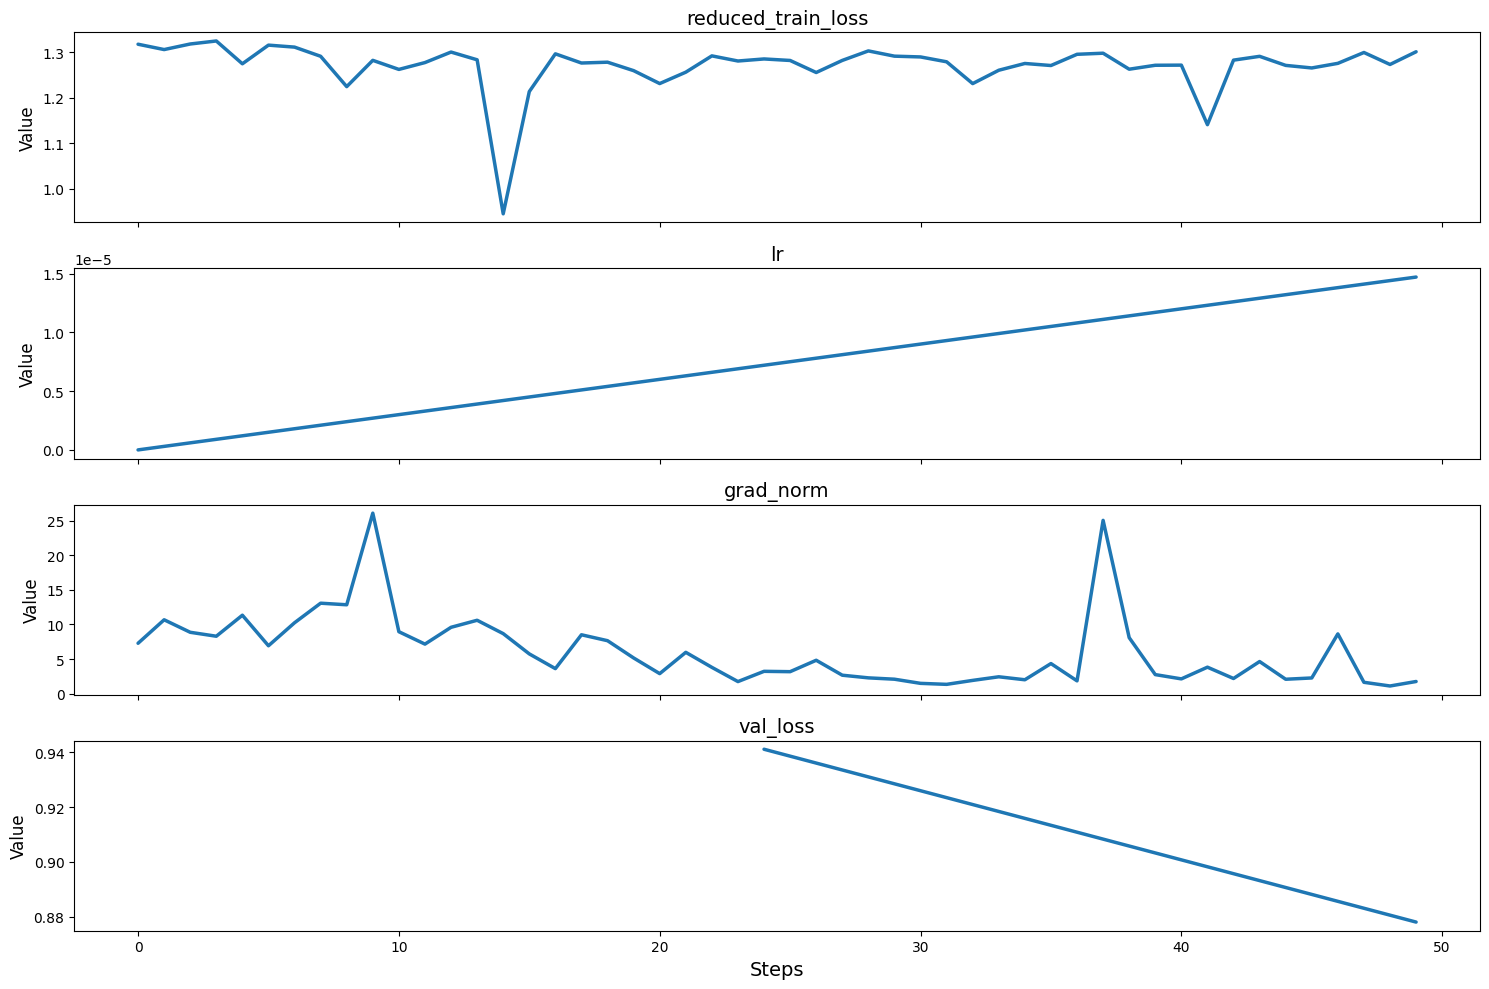

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorboard.backend.event_processing.event_accumulator as event_accumulator


# Function to extract data from TensorBoard event files and convert to DataFrame
def tensorboard_to_dataframe(event_file):
    # Load the event file
    ea = event_accumulator.EventAccumulator(event_file,
                                           size_guidance={
                                               event_accumulator.SCALARS: 0,  # 0 means load all
                                           })
    ea.Reload()

    # Get list of all available tags
    tags = ea.Tags()['scalars']

    # First, find the union of all steps
    all_steps = set()
    for tag in tags:
        events = ea.Scalars(tag)
        steps = [event.step for event in events]
        all_steps.update(steps)

    # Sort steps for proper ordering
    all_steps = sorted(all_steps)

    # Initialize the dataframe with steps
    df = pd.DataFrame({'step': all_steps})

    # Add each metric as a column
    for tag in tags:
        events = ea.Scalars(tag)
        # Create a dictionary mapping steps to values
        step_to_value = {event.step: event.value for event in events}
        # Add the values to the dataframe, using NaN for missing steps
        df[tag] = df['step'].map(step_to_value)

    return df

# Example of creating a multi-metric plot with seaborn
def plot_multiple_metrics(df, metrics_to_plot, figsize=(15, 10)):
    n = len(metrics_to_plot)
    fig, axes = plt.subplots(n, 1, figsize=figsize, sharex=True)

    if n == 1:  # Handle the case of a single plot
        axes = [axes]

    sns.set_style("whitegrid")

    for i, metric in enumerate(metrics_to_plot):
        if metric in df.columns:
            sns.lineplot(x='step', y=metric, data=df, ax=axes[i], linewidth=2.5, errorbar='sd')
            axes[i].set_title(metric, fontsize=14)
            axes[i].set_ylabel('Value', fontsize=12)
    axes[-1].set_xlabel('Steps', fontsize=14)
    plt.tight_layout()
    plt.show()


# Get the TensorBoard event file for the training run
log_dirs = !find pretraining_demo -name "events.out.tfevents*"
tf_event_file = log_dirs[0]

# Extract data from your event file
df = tensorboard_to_dataframe(tf_event_file)
# You can uncomment and modify this to plot multiple metrics once you see what's available
plot_multiple_metrics(df, ['reduced_train_loss', 'lr', 'grad_norm', "val_loss"])

### Next steps
On a small number of devices, or with the small demo fasta we provided in this tutorial, it's possible you are not at the needed
1.08 loss level to get good downstream accuracy out of this checkpoint. You can try increasing the `MAX_STEPS` parameter in the training cell,
or running a larger cluster with more GPUs.

![Training curve with a global batch size of 256 achieves 1.08 loss in approximately 100 steps](media/1b_finetuning_train_curve_500_steps_256gbs.png)

The final checkpoint path that you can try using in the BRCA1 zero shot tutorial is the following:

In [2]:
final_ckpt_paths = !ls -d pretraining_demo/*-last
final_ckpt_path = final_ckpt_paths[-1]
final_ckpt_path

'pretraining_demo/default--val_loss=0.9412-epoch=0-consumed_samples=400.0-last'